# Deconvolution Using In-House V2 Panel

Here we will construct reference matrix to estimate standard cell-type proportions using in-house v2 panel. Our focus is on CRC/AA samples. Thus we will only include broad immune cell-types, abundant non-immune cell-types and colon/small-intestine epithelial cells.

## Initialisation

In [58]:
import os
import numpy as np
import pandas as pd
import random
import glob
import datetime
import itertools
import seaborn as sns

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)

### Parameters and File Paths

In [59]:
FILTER_COV = 10
SCORE_VAR = 'frac_alpha_leq_25pct'
#--- Local paths
ROOT_DIR = '/analysis/gh-msun/projects'
PROJECT_SLUG = '2023_06_26_SRT_deconvolution_MS'
PROJECT_DIR = ROOT_DIR + '/{}'.format(PROJECT_SLUG)
DATA_DIR = ROOT_DIR + '/{}'.format(PROJECT_SLUG) + '/stage'

SAMPLE_PATH = DATA_DIR + '/metadata/samples_wgbs.20230329.tsv'

# # Methylation scores for reference WGBS samples.
# SCORE_PATH = (
#     DATA_DIR + '/ref_methyl_summaries/meth_summaries_cg_count_geq_3_deconvolution_v2.v23_conv.tsv.gz'
# )
SCORE_PATH = (
    '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/output/meth_summaries/blueprint_meth_summaries_cg_count_geq_3_deconvolution_v2.v23_conv.with_cpg_index.tsv.gz'
)

# Region annotation
REGION_PATH = (
    DATA_DIR + '/panel_data/deconvolution_v2.v23_panel_design.tsv.gz'
)
# Where to store deconvolution results
RESULTS_PATH = (
    PROJECT_DIR + '/output/deconv_inhouse_v2'
)

### Sample Metadata

In [60]:
SCORE_PATH

'/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/output/meth_summaries/blueprint_meth_summaries_cg_count_geq_3_deconvolution_v2.v23_conv.with_cpg_index.tsv.gz'

In [61]:
sample_df = pd.read_csv(SAMPLE_PATH, sep='\t')
ridxs = sample_df['source'].isin(['blueprint_loyfer2022'])
sample_df = sample_df[ridxs].copy()

In [62]:
sample_df.head()

,sample_id,patient_id,cell_type,sample_group,age,source,stage_group,tumor_purity
0,GSM5652176,Z000000T7,Adipocytes,Adipocytes,53.0,blueprint_loyfer2022,NaN,NaN
1,GSM5652177,Z000000T9,Adipocytes,Adipocytes,35.0,blueprint_loyfer2022,NaN,NaN
2,GSM5652178,Z000000T5,Adipocytes,Adipocytes,37.0,blueprint_loyfer2022,NaN,NaN
3,GSM5652179,Endothelium,Endothelium,Endothelium,33.0,blueprint_loyfer2022,NaN,NaN
4,GSM5652180,Endothelium,Endothelium,Endothelium,62.0,blueprint_loyfer2022,NaN,NaN


In [82]:
sample_df['cell_type'].unique()

array(['Adipocytes', 'Endothelium', 'Fibroblast', 'Striated muscle',
       'Smooth muscle', 'Cardiomyocyte', 'Osteoblasts',
       'Oligodendrocytes', 'Neuronal', 'Hepatocyte', 'Duct', 'Acinar',
       'Delta', 'Beta', 'Alpha', 'Epithelium', 'Podocyte',
       'Erythrocyte progenitors', 'T (CD3+) cells',
       'T helper(CD4+) cells', 'T cytotoxic (CD8+) cells',
       'T central memory CD4', 'T effector cell CD8',
       'T effector memory CD4', 'T effector memory CD8',
       'Naive T cells CD4', 'Naive T cells CD8', 'NK', 'Monocytes',
       'Macrophages', 'Granulocytes', 'B cells', 'Memory B cells',
       'keratinocyte', 'Luminal epithelial', 'Basal epithelial',
       'Endocrine', 'endothelial cell of umbilical vein (proliferating)',
       'endothelial cell of umbilical vein (resting)',
       'band form neutrophil', 'neutrophilic metamyelocyte',
       'neutrophilic myelocyte', 'segmented neutrophil of bone marrow',
       'precursor B cell', 'precursor lymphocyte of B lineage

In [83]:
sample_df['sample_group'].unique()

array(['Adipocytes', 'Endothelium', 'Colon-Fibro', 'Heart-Fibro',
       'Dermal-Fibro', 'Skeletal-Musc', 'Smooth-Musc', 'Heart-Cardio',
       'Bone-Osteob', 'Oligodend', 'Neuron', 'Liver-Hep', 'Pancreas-Duct',
       'Pancreas-Acinar', 'Pancreas-Delta', 'Pancreas-Beta',
       'Pancreas-Alpha', 'Kidney-Ep', 'Thyroid-Ep', 'Fallopian-Ep',
       'Ovary+Endom-Ep', 'Eryth-prog', 'Blood-T', 'Blood-NK',
       'Blood-Mono+Macro', 'Blood-Granul', 'Blood-B', 'Epid-Kerat',
       'Head-Neck-Ep', 'Lung-Ep-Bron', 'Prostate-Ep', 'Bladder-Ep',
       'Breast-Luminal-Ep', 'Breast-Basal-Ep', 'Lung-Ep-Alveo',
       'Gallbladder', 'Gastric-Ep', 'Colon-Ep', 'Small-Int-Ep',
       'Umbilical-Endothelium', 'Blueprint-Neutro', 'Blueprint-B',
       'Blueprint-Mono', 'Blueprint-CD8', 'Blueprint-NK',
       'Blueprint-Macro', 'Blueprint-Eryth', 'Blueprint-Mega',
       'Blueprint-Dend', 'Blueprint-CD4', 'Blueprint-Eosi'], dtype=object)

In [63]:
sample_df['source'].unique()

array(['blueprint_loyfer2022'], dtype=object)

In [64]:
summary = sample_df\
    .fillna('none')\
    .groupby(['sample_group'])\
    .size()
summary

sample_group
Adipocytes                3
Bladder-Ep                5
Blood-B                   5
Blood-Granul              3
Blood-Mono+Macro         11
Blood-NK                  3
Blood-T                  22
Blueprint-B              17
Blueprint-CD4            14
Blueprint-CD8            10
Blueprint-Dend            2
Blueprint-Eosi            2
Blueprint-Eryth           2
Blueprint-Macro          18
Blueprint-Mega            2
Blueprint-Mono            8
Blueprint-NK              4
Blueprint-Neutro         21
Bone-Osteob               1
Breast-Basal-Ep           4
Breast-Luminal-Ep         3
Colon-Ep                  8
Colon-Fibro               2
Dermal-Fibro              1
Endothelium              19
Epid-Kerat                1
Eryth-prog                3
Fallopian-Ep              3
Gallbladder               1
Gastric-Ep               11
Head-Neck-Ep             13
Heart-Cardio              6
Heart-Fibro               4
Kidney-Ep                 8
Liver-Hep                 6
Lung-Ep

### Regions

In [65]:
region_df = pd.read_csv(REGION_PATH, sep='\t')
ridxs = (region_df['v23_conv']==1)
region_df = region_df[ridxs].copy()
region_df.shape[0], region_df['region_id'].nunique()

(1930, 1658)

Duplication is due to the fact that some regions are spread across several MSRE cut-site clusters.

In [66]:
region_df = region_df[['region_id', 'subpanel', 'target_celltype']].drop_duplicates()
region_df.shape[0], region_df['region_id'].nunique()

(1658, 1658)

In [67]:
summary = region_df.groupby(['subpanel', 'target_celltype']).size()
summary

subpanel            target_celltype                                      
external            Literature_Age                                            30
                    Literature_Immune                                         30
                    Loyfer2022_Preprint_Blood-B                               13
                    Loyfer2022_Preprint_Blood-Granul                          13
                    Loyfer2022_Preprint_Blood-Mono+Macro                      15
                    Loyfer2022_Preprint_Blood-NK                              13
                    Loyfer2022_Preprint_Blood-T                               16
                    Loyfer2022_Preprint_Breast-Basal-Ep                       25
                    Loyfer2022_Preprint_Breast-Basal-Ep:Breast-Luminal-Ep     22
                    Loyfer2022_Preprint_Colon-Ep                              13
                    Loyfer2022_Preprint_Colon-Ep:Gastric-Ep:Small-Int-Ep      14
                    Loyfer2022_Prep

In [68]:
# ridxs = region_df['subpanel'].isin(['external','immune_broad','immune_refined','immune_specialised'])
# region_df = region_df[ridxs]
# region_df.shape[0], region_df['region_id'].nunique()

### Methylation Scores

In [69]:
score_df = pd.read_csv(SCORE_PATH, sep='\t')
ridxs = score_df['sample_id'].isin(sample_df['sample_id'])
ridxs &= score_df['region_id'].isin(region_df['region_id'])
score_df = score_df[ridxs].copy()
score_df.shape[0], score_df['region_id'].nunique()

(168489, 1648)

In [70]:
score_df = pd.read_csv(SCORE_PATH, sep='\t')
score_df

,sample_id,region_id,number_molecules,meth_k1,unmeth_k1,total_k1,meth_k3,unmeth_k3,total_k3,meth_k4,unmeth_k4,total_k4,frac_alpha_leq_25pct,frac_alpha_geq_75pct
0,ERS1022343,Immune_Broad_Neutro-chr1:9147789-9147871,21,64,6,70,23,1,27,5,0,7,0.047619,0.904762
1,ERS1112536,Immune_Broad_Neutro-chr1:9147789-9147871,18,51,17,68,15,0,32,5,0,14,0.111111,0.666667
2,ERS1112540,Immune_Broad_Neutro-chr1:9147789-9147871,13,32,16,48,9,3,20,4,1,9,0.153846,0.538462
3,ERS1138462,Immune_Broad_Neutro-chr1:9147789-9147871,23,65,23,88,20,4,42,8,1,19,0.173913,0.695652
4,ERS1138463,Immune_Broad_Neutro-chr1:9147789-9147871,15,42,9,51,14,1,21,2,0,6,0.066667,0.866667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206298,ERS985317,Loyfer2022_Preprint_Colon-Fibro:Heart-Fibro_ch...,14,36,13,49,11,2,19,3,0,6,0.142857,0.642857
206299,ERS985318,Loyfer2022_Preprint_Colon-Fibro:Heart-Fibro_ch...,9,26,3,29,8,0,11,2,0,2,0.000000,0.666667
206300,ERS985319,Loyfer2022_Preprint_Colon-Fibro:Heart-Fibro_ch...,7,18,5,23,6,1,9,2,0,2,0.142857,0.571429
206301,ERS985320,Loyfer2022_Preprint_Colon-Fibro:Heart-Fibro_ch...,5,18,1,19,5,0,7,2,0,3,0.000000,1.000000


In [71]:
ridxs = score_df['sample_id'].isin(sample_df['sample_id'])
ridxs

0          True
1         False
2         False
3          True
4          True
          ...  
206298    False
206299    False
206300    False
206301    False
206302    False
Name: sample_id, Length: 206303, dtype: bool

## Construct Reference Matrix

What samples/regions define reference atlas?

In [72]:
SAMPLE_TO_REF_CELLTYPE_MAP = {   # blue print
    'Blueprint-B': 'immune_b',
    'Blueprint-CD4': 'immune_t',
    'Blueprint-CD8': 'immune_t',
    'Blueprint-NK': 'immune_nk',
    'Blueprint-Dend': 'immune_dend_plus_macro_plus_mono',
    'Blueprint-Macro': 'immune_dend_plus_macro_plus_mono',
    'Blueprint-Mono': 'immune_dend_plus_macro_plus_mono',
    'Blueprint-Eosi': 'immune_eosi',
    'Blueprint-Neutro': 'immune_neutro',
    'Blueprint-Eryth': 'immune_eryth',
    'Blueprint-Mega': 'immune_mega',
    'Eryth-prog': 'eryth_prog',
}
REGION_TO_REF_CELLTYPE_MAP = {  # hypo panel
    'Immune_Broad_B': 'immune_b',
    'Immune_Broad_CD4_plus_CD8': 'immune_t',
    'Immune_Broad_NK': 'immune_nk',
    'Immune_Broad_Dend_plus_Macro_plus_Mono': 'immune_dend_plus_macro_plus_mono',
    'Immune_Broad_Eosi': 'immune_eosi',
    'Immune_Broad_Neutro': 'immune_neutro',
    'Immune_Refined_Eryth': 'immune_eryth',
    'Immune_Refined_Mega': 'immune_mega',
    'Eryth_prog': 'eryth_prog',
} 

In [73]:
ridxs = (sample_df['source']=='blueprint_loyfer2022')
ridxs &= sample_df['sample_group'].isin(SAMPLE_TO_REF_CELLTYPE_MAP.keys())
ref_sample_df = sample_df[ridxs].copy()
ref_sample_df['ref_celltype'] = ref_sample_df['sample_group'].map(SAMPLE_TO_REF_CELLTYPE_MAP)
ref_sample_df.shape[0], ref_sample_df['sample_id'].nunique(), ref_sample_df['ref_celltype'].nunique()

(103, 103, 9)

In [74]:
ridxs = region_df['target_celltype'].isin(REGION_TO_REF_CELLTYPE_MAP.keys())
ref_region_df = region_df[ridxs][['region_id', 'target_celltype']].drop_duplicates()
ref_region_df['ref_celltype'] = ref_region_df['target_celltype'].map(REGION_TO_REF_CELLTYPE_MAP)
ref_region_df.shape[0], ref_region_df['region_id'].nunique(), ref_region_df['ref_celltype'].nunique()

(301, 301, 9)

In [75]:
# number of regions per cell type
ref_region_df.groupby(['ref_celltype'])['region_id'].nunique()

ref_celltype
eryth_prog                          22
immune_b                            49
immune_dend_plus_macro_plus_mono    13
immune_eosi                         38
immune_eryth                        25
immune_mega                         29
immune_neutro                       29
immune_nk                           53
immune_t                            43
Name: region_id, dtype: int64

In [76]:
ridxs = (score_df['number_molecules']>=FILTER_COV)
ridxs &= score_df['sample_id'].isin(ref_sample_df['sample_id'])
ridxs &= score_df['region_id'].isin(ref_region_df['region_id'])
atlas = score_df[ridxs][['sample_id', 'region_id', SCORE_VAR]]\
    .merge(ref_sample_df[['sample_id', 'ref_celltype']])\
    .groupby(['region_id', 'ref_celltype'])\
    [SCORE_VAR].mean()\
    .reset_index()\
    .pivot_table(index='region_id', columns='ref_celltype', values=SCORE_VAR)
atlas.shape

(301, 8)

In [77]:
ridxs = (atlas.isna().sum(axis=1)==0)
atlas = atlas[ridxs].copy()
atlas.shape

(280, 8)

Rearrange columns and rows of atlas matrix to conform to desired order.

In [78]:
ref_region_df = pd.DataFrame({'ref_celltype': list(REGION_TO_REF_CELLTYPE_MAP.values())})\
    .drop_duplicates()\
    .merge(ref_region_df)
ridxs = ref_region_df['region_id'].isin(atlas.index)
ref_region_df = ref_region_df[ridxs].copy()
ref_sample_df = pd.DataFrame({'ref_celltype': list(SAMPLE_TO_REF_CELLTYPE_MAP.values())})\
    .drop_duplicates()\
    .merge(ref_sample_df)
atlas = atlas.loc[ref_region_df['region_id'], ref_sample_df['ref_celltype'].unique()]
atlas.shape

KeyError: "['eryth_prog'] not in index"

In [79]:
ref_sample_df

,ref_celltype,sample_id,patient_id,cell_type,sample_group,age,source,stage_group,tumor_purity
0,immune_b,ERS666927,F2012-2912,precursor B cell,Blueprint-B,0 - 5,blueprint_loyfer2022,NaN,NaN
1,immune_b,ERS337605,F2012-2912,precursor lymphocyte of B lineage,Blueprint-B,0 - 5,blueprint_loyfer2022,NaN,NaN
2,immune_b,ERS337607,MO7071,plasma cell,Blueprint-B,20 - 30,blueprint_loyfer2022,NaN,NaN
3,immune_b,ERS666931,V156,plasma cell,Blueprint-B,20 - 30,blueprint_loyfer2022,NaN,NaN
4,immune_b,ERS214672,C003K9,CD38-negative naive B cell,Blueprint-B,0 - 5,blueprint_loyfer2022,NaN,NaN
5,immune_b,ERS214675,C0068L,CD38-negative naive B cell,Blueprint-B,0 - 5,blueprint_loyfer2022,NaN,NaN
6,immune_b,ERS222206,C003JB,class switched memory B cell,Blueprint-B,55 - 60,blueprint_loyfer2022,NaN,NaN
7,immune_b,ERS222208,C003N3,memory B cell,Blueprint-B,50 - 55,blueprint_loyfer2022,NaN,NaN
8,immune_b,ERS568736,csMBC pool 1,memory B cell,Blueprint-B,20 - 40,blueprint_loyfer2022,NaN,NaN
9,immune_b,ERS666930,NC11_41,class switched memory B cell,Blueprint-B,60 - 65,blueprint_loyfer2022,NaN,NaN


## Reference Matrix Heatmap

In [53]:
## Make the heatmap with R - not necessary if R is not installed
# %%R -i atlas,ref_region_df,RESULTS_PATH
# library(tidyverse)
# library(pheatmap)
# library(pals)

# save_pheatmap_pdf <- function(x, filename, width=12, height=14) {
#    stopifnot(!missing(x))
#    stopifnot(!missing(filename))
#    pdf(filename, width=width, height=height)
#    grid::grid.newpage()
#    grid::grid.draw(x$gtable)
#    dev.off()
# }

# # Cell-type annotation
# col_annot = data.frame(celltype=colnames(atlas))
# rownames(col_annot) = colnames(atlas)
# celltype_colors = c(stepped(), stepped2())[1:length(colnames(atlas))]
# names(celltype_colors) = colnames(atlas)
# # Region annotation
# row_annot = data.frame(region_celltype=ref_region_df$ref_celltype)
# rownames(row_annot) = ref_region_df$region_id
# region_celltype_colors = c(stepped(), stepped2())[1:length(unique(ref_region_df$ref_celltype))]
# names(region_celltype_colors) = unique(ref_region_df$ref_celltype)
# annot_colors = list(celltype=celltype_colors, region_celltype=region_celltype_colors)
# # Heatmap
# p = pheatmap(
#     atlas, 
#     cluster_rows=FALSE, show_rownames=FALSE, 
#     cluster_cols=FALSE, show_colnames=FALSE, 
#     annotation_colors=annot_colors,
#     annotation_row=row_annot, annotation_names_row=FALSE,
#     annotation_col=col_annot, annotation_names_col=FALSE,
#     scale='none', clustering_method='ward.D2',
# )
# ofile <- sprintf('%s_heatmap_atlas.pdf', RESULTS_PATH)
# save_pheatmap_pdf(p, file=ofile)

In [84]:
atlas.shape

(280, 8)

In [85]:
atlas.head()

ref_celltype,immune_b,immune_dend_plus_macro_plus_mono,immune_eosi,immune_eryth,immune_mega,immune_neutro,immune_nk,immune_t
region_id,,,,,,,,
Eryth_prog-chr12:122875429-122875559,0.005622,0.006410,0.0,0.000000,0.0,0.010157,0.000000,0.000000
Eryth_prog-chr12:123471883-123472181,0.003979,0.001896,0.0,0.002688,0.0,0.005374,0.006139,0.002178
Eryth_prog-chr14:20871852-20872002,0.004298,0.005273,0.0,0.008929,0.0,0.003809,0.000000,0.002338
Eryth_prog-chr16:15790488-15790760,0.007975,0.002855,0.0,0.000000,0.0,0.003592,0.000000,0.002749
Eryth_prog-chr16:4494669-4494777,0.000000,0.000812,0.0,0.000000,0.0,0.005211,0.008621,0.009374


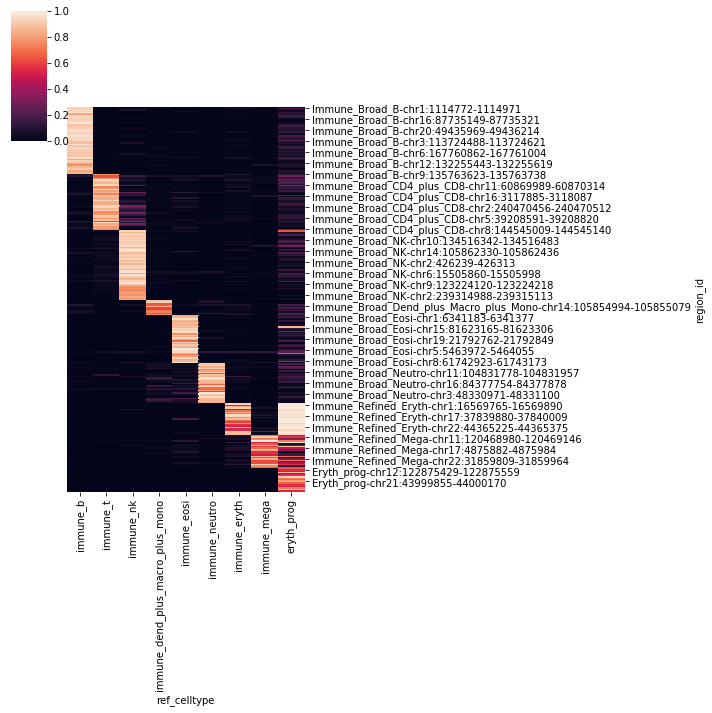

In [55]:
sns.clustermap(atlas, row_cluster=False, col_cluster=False)

## SVD Decomposition of Atlas

In [38]:
u, s, v = np.linalg.svd(atlas, compute_uv=True, full_matrices=False)
s

array([7.57730483, 6.37619956, 6.28059318, 5.22775602, 5.16497951,
       4.5205919 , 3.48490308, 2.44184816, 1.90873604])

## Write Out

Reference atlas.

In [39]:
ofile = RESULTS_PATH + '.atlas.tsv.gz'
rv = atlas.reset_index()
rv.to_csv(ofile, sep='\t', header=True, index=False)

Region to reference cell type mapping.

In [40]:
ofile = RESULTS_PATH + '.region_to_ref_celltype.tsv.gz'
rv = ref_region_df[['region_id', 'ref_celltype']].copy()
rv.to_csv(ofile, sep='\t', header=True, index=False)

Sample to reference cell type mapping.

In [41]:
ofile = RESULTS_PATH + '.sample_to_ref_celltype.tsv.gz'
rv = ref_sample_df[['sample_id', 'ref_celltype']].copy()
rv.to_csv(ofile, sep='\t', header=True, index=False)